# Implementing a Convolutional Neural Network and training it with the MNIST handwriting dataset.

I will try to implement this using PyTorch, and if not, I will find some way to implement the CNN.

### Libraries needed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import optim
from torch import nn


from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [2]:
import os
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Data

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

training_data = datasets.MNIST(root="data", train=True, download=False, transform=transform)
test_data = datasets.MNIST(root="data", train=False, download=False,transform=transform)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

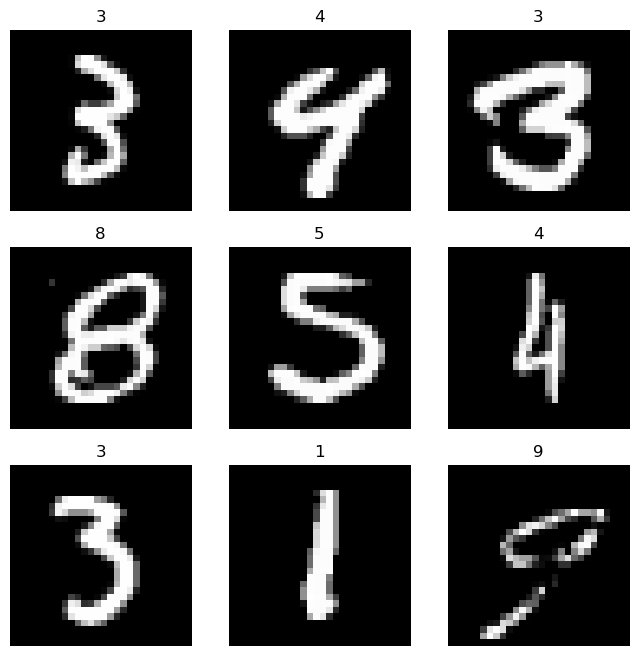

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


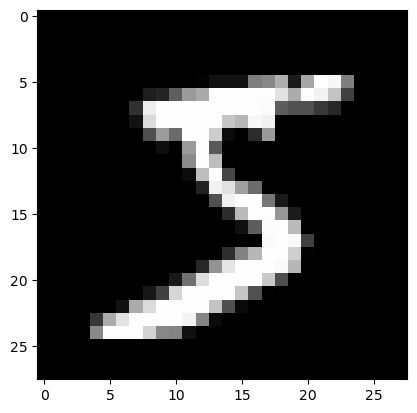

Label: 5


In [9]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### Model

In [39]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # 28x28 -> 14x14
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # 14x14 -> 7x7
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # 7x7 -> 3x3
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


### Train and Evaluation classes

In [40]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size = 64):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, batch_size = 64):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.3f}%, Avg loss: {test_loss:>8f} \n")

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, batch_size=64)
    test_loop(test_dataloader, model, loss_fn, batch_size=64)
print("Done!")

Epoch 1
-------------------------------
loss: 2.322304  [   64/60000]
loss: 0.736407  [ 6464/60000]
loss: 0.310694  [12864/60000]
loss: 0.346138  [19264/60000]
loss: 0.300912  [25664/60000]
loss: 0.301801  [32064/60000]
loss: 0.122561  [38464/60000]
loss: 0.214785  [44864/60000]
loss: 0.383546  [51264/60000]
loss: 0.248352  [57664/60000]
Test Error: 
 Accuracy: 97.720%, Avg loss: 0.077650 

Epoch 2
-------------------------------
loss: 0.172412  [   64/60000]
loss: 0.207199  [ 6464/60000]
loss: 0.134549  [12864/60000]
loss: 0.219399  [19264/60000]
loss: 0.161720  [25664/60000]
loss: 0.198127  [32064/60000]
loss: 0.116810  [38464/60000]
loss: 0.124697  [44864/60000]
loss: 0.157893  [51264/60000]
loss: 0.187126  [57664/60000]
Test Error: 
 Accuracy: 98.800%, Avg loss: 0.044415 

Epoch 3
-------------------------------
loss: 0.132009  [   64/60000]
loss: 0.147862  [ 6464/60000]
loss: 0.101280  [12864/60000]
loss: 0.220767  [19264/60000]
loss: 0.063203  [25664/60000]
loss: 0.095387  [32064